# Head

## Setup some packs

In [ ]:
# GPU testing
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13191447140288113757
 xla_global_id: -1]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark
!pip install --pre --upgrade bigdl-chronos
!pip install pytorch_lightning==1.6.0
# !pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=79228e47fa7ff2df8177a2753ffbe2390ef533c600c370d057fae3a38f761d00
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling s

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.1/582.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.5
    Uninstalling protobuf-3.19.5:
      Successfully uninstalled protobuf-3.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigdl-nano 2.4.0b20230721 requires protobuf==3.19.5, but you have protobuf 4.23.4 which is incompatible.


In [ ]:
!sudo apt-get install python3.7
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --config python3
!sudo apt install python3-pip
!python --version

In [ ]:
from IPython.display import display, clear_output
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as f
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.sql.functions import udf
from pyspark.sql.streaming import DataStreamReader
import html

pd.options.display.max_columns = None
pd.options.display.max_rows = 30
pd.options.display.max_colwidth = 150



# SETTINGS
IN_PATH = "/content/drive/MyDrive/big data/final_data.csv"
timestampformat = "EEE MMM dd HH:mm:ss zzzz yyyy"

spark = SparkSession.builder.appName("StructuredStreamingExample").getOrCreate()
schema = spark.read.option('header',True).csv(IN_PATH).limit(10).schema

spark_reader = spark.read.option('header', True).schema(schema)

In [ ]:
df = (
    spark_reader.csv(IN_PATH)
    .select(
        "timestamp",
        "inhouse_temperature",
        "inhouse_humidity",
        "temp",
        "weather",
        "wind_speed",
        "humidity",
        "barometer",
        "visibility"
    )
    .coalesce(1)
)

In [ ]:
df.toPandas()

## Preprocessing data

In [ ]:
def weather_label(s: str):
  normal = ['Passing clouds.', 'Scattered clouds.', 'Partly cloudy.', 'Broken clouds.', 'Fog.',\
            'Clear.', 'Mostly cloudy.', 'More clouds than sun.', 'Haze.',]

  sunny = ['Warm.', 'Sunny.', 'Partly sunny.', 'Hot.',]

  rain = ['Lots of rain. Scattered clouds.', 'Thundershowers. Passing clouds.', 'Lots of rain. Partly sunny.',\
          'Thunderstorms. Passing clouds.', 'Thundershowers. Broken clouds.', 'Lots of rain. Broken clouds.',\
          'Thundershowers. Partly cloudy.', 'Rain. Broken clouds.', 'Thundershowers. Scattered clouds.',\
          'Rain. Passing clouds.', 'Lots of rain. Fog.', 'Rain. Mostly cloudy.', 'Rain. Partly cloudy.', 'Rain. Fog.',\
          'Lots of rain. Passing clouds.', 'Rain. Partly sunny.', 'Thundershowers. Partly sunny.', 'Rain. Scattered clouds.',]

  light_rain = ['Sprinkles. Scattered clouds.', 'Rain showers. Scattered clouds.', 'Light rain. Passing clouds.',\
                'Sprinkles. Broken clouds.', 'Light rain. Broken clouds.', 'Rain showers. Partly sunny.', 'Light rain. Partly cloudy.',\
                'Sprinkles. Passing clouds.', 'Sprinkles. Partly sunny.', 'Rain showers. Broken clouds.', 'Scattered showers. Partly sunny.',\
                'Scattered showers. Broken clouds.', 'Scattered showers. Scattered clouds.', 'Sprinkles. Partly cloudy.',\
                'Rain showers. Passing clouds.', 'Light rain. Scattered clouds.', 'Rain showers. Partly cloudy.', 'Light rain. Partly sunny.',\
                'Rain showers. Fog.', 'Light rain. More clouds than sun.', 'Scattered showers. Passing clouds.', 'Light rain. Fog.',\
                'Light rain. Mostly cloudy.', 'Rain showers. More clouds than sun.',]

  will_rain = ['Strong thunderstorms. Partly cloudy.', 'Thunderstorms. Partly sunny.', 'Strong thunderstorms. Broken clouds.',\
               'Thunderstorms. Partly cloudy.', 'Strong thunderstorms. Scattered clouds.', 'Thunderstorms. Scattered clouds.',\
               'Thunderstorms. Broken clouds.', 'Strong thunderstorms. Broken clouds.', 'Overcast.', 'Thunderstorms. More clouds than sun.',\
               'Strong thunderstorms. More clouds than sun.', 'Strong thunderstorms. Passing clouds.', 'Strong thunderstorms. Partly sunny.',\
               'Thunderstorms. Fog.',]

  if s in normal:
    return 0
  if s in sunny:
    return 1
  if s in rain:
    return 2
  if s in light_rain:
    return 3
  if s in will_rain:
    return 4
  return 0


def clean_data(df: DataFrame):
    weather_udf = udf(lambda x:weather_label(x))
    return (
        df
        .withColumn("timestamp", df.timestamp.cast('double'))
        .withColumn("date", f.to_timestamp(f.from_unixtime(f.col("timestamp") / 1000)))
        .withColumn("inhouse_humidity", df.inhouse_humidity.cast('double'))
        .withColumn("inhouse_temperature", df.inhouse_temperature.cast('double'))
        .withColumn("temp", (f.regexp_extract(df.temp, r"\d+", 0).cast('double')))
        .withColumn("wind_speed", f.when(f.col('wind_speed')=="No wind", 0).otherwise(f.regexp_extract(df.wind_speed, r"\d+", 0)).cast('double'))
        .withColumn("humidity", f.when(f.col('humidity')=="N/A", -1).otherwise(f.regexp_extract(df.humidity, r"\d+", 0).cast('double')))
        .withColumn("barometer", f.when(f.col('barometer')=="N/A", -1).otherwise(f.regexp_extract(df.barometer, r"\d+", 0).cast('double')))
        .withColumn("visibility", f.when(f.col('visibility')=="N/A", -1).otherwise(f.regexp_extract(df.visibility, r"\d+", 0)).cast('double'))
        .withColumn("weather", weather_udf(f.col('weather')).cast('double'))
    )
df = clean_data(df).sort(f.col("date")).na.drop()

In [ ]:
df.show()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

stages = []
cols = ['inhouse_temperature', 'inhouse_humidity', 'temp', 'weather', 'wind_speed', 'humidity', 'barometer', 'visibility']
assemblerInputs = cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
pipeline = Pipeline(stages=stages)
model = pipeline.fit(df)

df_transformed = model.transform(df).na.drop()

In [ ]:
!pip install bigdl-orca

In [ ]:
# Sorting dataframe by date, drop nan values and turn it into pandas dataframe
df_pd = df.toPandas()

In [ ]:
# Create new_date column to group some rows by minutes
data = pd.DataFrame(df_pd)
data['new_date'] = data['date'].apply(lambda x:str(x)[:-3])

drop_columns = ['timestamp', 'date',] #
data = data.drop(drop_columns, axis  = 1) # drop columns that is no longer important

data = data.groupby(by='new_date', as_index = False).mean()
# data = data[data['new_date'].str.contains(':00')].reset_index().drop(['index'], axis=1)
data['new_date'] = pd.to_datetime(data['new_date']+":00")

In [ ]:
# data.set_index('new_date')

## Save dataframe or samples

In [ ]:
data[-39564:-39559].to_csv("/content/streaming/run.csv", index=False)
#-39563:-39558

## inhouse_temperature ploting

In [ ]:
data.set_index('new_date')['inhouse_temperature'].plot(figsize=(12, 5))

In [ ]:
df_transformed.show()

+-----------------+-------------------+----------------+----+-------+----------+--------+---------+----------+-------------------+--------------------+
|        timestamp|inhouse_temperature|inhouse_humidity|temp|weather|wind_speed|humidity|barometer|visibility|               date|            features|
+-----------------+-------------------+----------------+----+-------+----------+--------+---------+----------+-------------------+--------------------+
|1.569906003023E12|               21.2|            72.5|19.0|    0.0|       9.0|    83.0|   1014.0|       1.0|2019-10-01 05:00:03|[21.2,72.5,19.0,0...|
|1.569906007226E12|               20.3|            75.2|19.0|    0.0|       9.0|    83.0|   1014.0|       1.0|2019-10-01 05:00:07|[20.3,75.2,19.0,0...|
|1.569906011857E12|               25.5|            55.9|19.0|    0.0|       9.0|    83.0|   1014.0|       1.0|2019-10-01 05:00:11|[25.5,55.9,19.0,0...|
|1.569906016208E12|               21.8|            70.3|19.0|    0.0|       9.0|    83.0

# TSDataset

## Split data

In [ ]:
!pip uninstall pyspark
!pip install pyspark

Found existing installation: pyspark 2.4.6
Uninstalling pyspark-2.4.6:
  Would remove:
    /usr/local/bin/beeline
    /usr/local/bin/beeline.cmd
    /usr/local/bin/docker-image-tool.sh
    /usr/local/bin/find-spark-home
    /usr/local/bin/find-spark-home.cmd
    /usr/local/bin/find_spark_home.py
    /usr/local/bin/load-spark-env.cmd
    /usr/local/bin/load-spark-env.sh
    /usr/local/bin/pyspark
    /usr/local/bin/pyspark.cmd
    /usr/local/bin/pyspark2.cmd
    /usr/local/bin/run-example
    /usr/local/bin/run-example.cmd
    /usr/local/bin/spark-class
    /usr/local/bin/spark-class.cmd
    /usr/local/bin/spark-class2.cmd
    /usr/local/bin/spark-shell
    /usr/local/bin/spark-shell.cmd
    /usr/local/bin/spark-shell2.cmd
    /usr/local/bin/spark-sql
    /usr/local/bin/spark-sql.cmd
    /usr/local/bin/spark-sql2.cmd
    /usr/local/bin/spark-submit
    /usr/local/bin/spark-submit.cmd
    /usr/local/bin/spark-submit2.cmd
    /usr/local/bin/sparkR
    /usr/local/bin/sparkR.cmd
    /usr/lo

In [ ]:
from bigdl.chronos.data.experimental.xshards_tsdataset import XShardsTSDataset

tsdata_train, tsdata_val, tsdata_test\
    = XShardsTSDataset.from_sparkdf(df_transformed, dt_col="date", target_col="inhouse_temperature"\
                                    ,extra_feature_col = ["timestamp","inhouse_humidity","temp","weather"\
                                                          ,"wind_speed","humidity","barometer","visibility"]\
                                    ,with_split=True, val_ratio=0.0, test_ratio=0.1)

In [ ]:
from bigdl.chronos.data.tsdataset import TSDataset
tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(data, dt_col="new_date", target_col=["inhouse_temperature", "inhouse_humidity", "temp",
                                                                                                  "weather", "wind_speed", "humidity", "barometer", "visibility"],
                                                               with_split=True, val_ratio=0.0, test_ratio=0.1)

## Lookback and horizon rolling on data

In [ ]:
lookback, horizon = 5, 1

for tsdata in [tsdata_train, tsdata_test]:
    tsdata.deduplicate()\
          .gen_dt_feature(features=['MINUTE', 'DAY', 'HOUR', 'MONTH', 'YEAR', ])\
          .impute()\
          .roll(lookback=lookback, horizon=horizon)

x, y = tsdata_train.to_numpy()
# x.shape = (num of sample, lookback, num of input feature)
# y.shape = (num of sample, horizon, num of output feature)

# Models

## TCNForecaster

In [ ]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster

# Model
tcn_forecaster = TCNForecaster(past_seq_len=lookback,  # number of steps to look back
                              future_seq_len=horizon,  # number of steps to predict
                              input_feature_num=x.shape[-1], # number of feature to use
                              output_feature_num=y.shape[-1],  # number of feature to predict
                              seed=1)

# Training model
res_tcn = tcn_forecaster.fit((x, y), epochs=3)

# Predict x_test
x_test, y_test = tsdata_test.to_numpy()
tcn_pred = tcn_forecaster.predict(x_test)

INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 5.7 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Mean Squared Error: 0.20735644


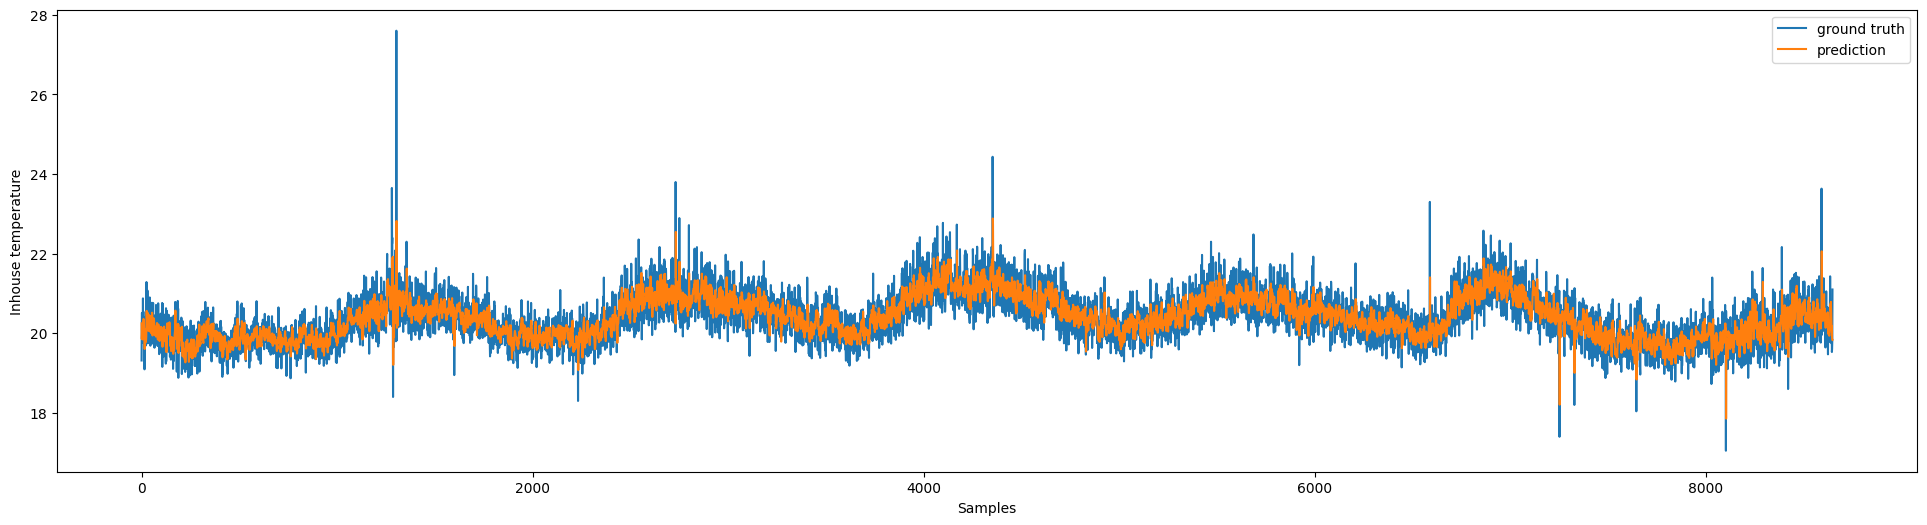

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
i=0
# MSE
mse = mean_squared_error(y_test[:,:,i], tcn_pred[:,:,i])
print('Mean Squared Error:', mse)

# Ploting
plt.figure(figsize=(24,6))
plt.plot(y_test[:,:,i])
plt.plot(tcn_pred[:,:,i])
plt.xlabel('Samples')
plt.ylabel('Inhouse temperature')
plt.legend(["ground truth", "prediction", ])

## LSTMForecaster

In [ ]:
from bigdl.chronos.forecaster.lstm_forecaster import LSTMForecaster

# Model
lstm_forecaster = LSTMForecaster(past_seq_len=lookback,  # number of steps to look back
                                input_feature_num=x.shape[-1], # number of feature to use
                                output_feature_num=y.shape[-1],  # number of feature to predict
                                seed=1)

# Training model
res_lstm = lstm_forecaster.fit((x, y), epochs=3)

# Predict x_test
x_test, y_test = tsdata_test.to_numpy()
lstm_pred = lstm_forecaster.predict(x_test)

INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 6.3 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Mean Squared Error: 0.20776777


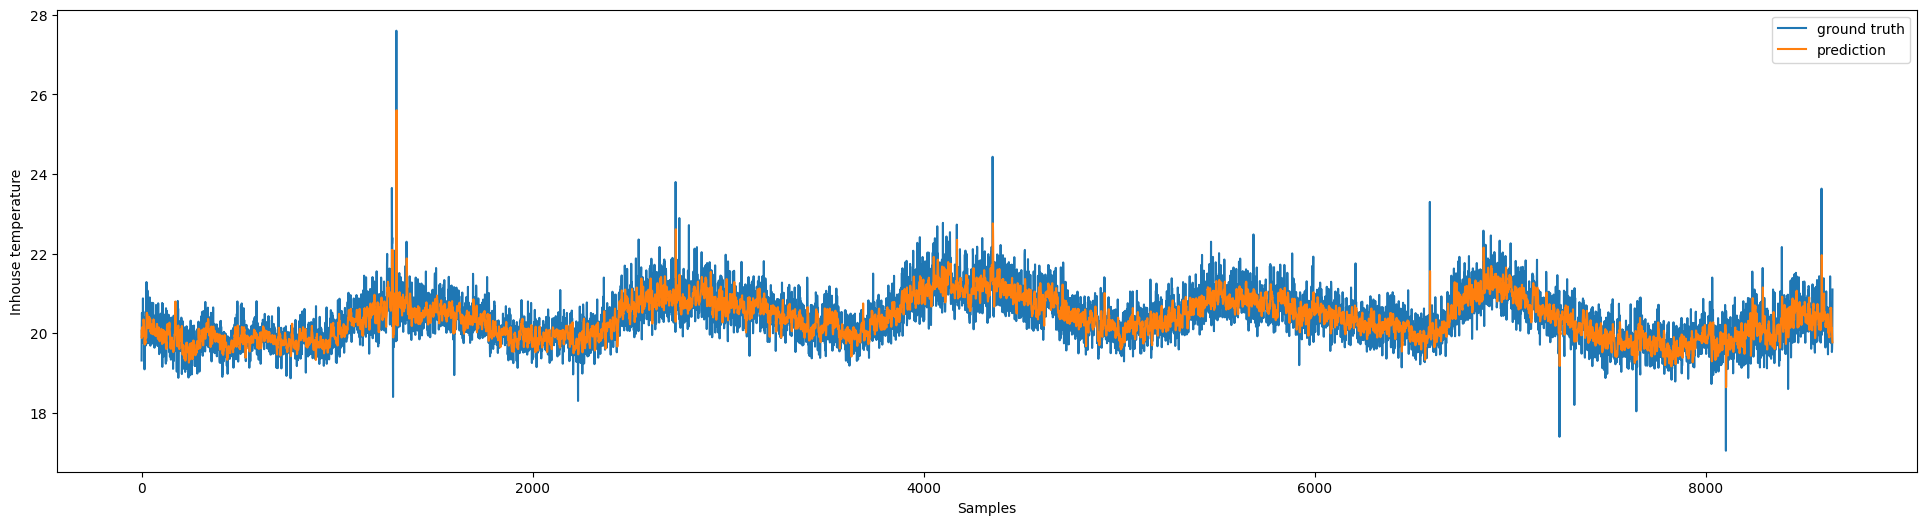

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
i=0
# MSE
mse = mean_squared_error(y_test[:,:,i], lstm_pred[:,:,i])
print('Mean Squared Error:', mse)

# Ploting
plt.figure(figsize=(24,6))
plt.plot(y_test[:,:,i])
plt.plot(lstm_pred[:,:,i])
plt.xlabel('Samples')
plt.ylabel('Inhouse temperature')
plt.legend(["ground truth", "prediction", ])

## Seq2Seq

In [ ]:
from bigdl.chronos.forecaster.seq2seq_forecaster import Seq2SeqForecaster

# Model
seq2seq_forecaster = Seq2SeqForecaster(past_seq_len=lookback,  # number of steps to look back
                           future_seq_len=horizon,  # number of steps to predict
                           input_feature_num=x.shape[-1], # number of feature to use
                           output_feature_num=y.shape[-1],  # number of feature to predict
                           seed=1)

# Training model
res_seq2seq = seq2seq_forecaster.fit((x, y), epochs=3)

# Predict x_test
x_test, y_test = tsdata_test.to_numpy()
seq2seq_pred = seq2seq_forecaster.predict(x_test)

INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 106 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.425     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Mean Squared Error: 0.20515943


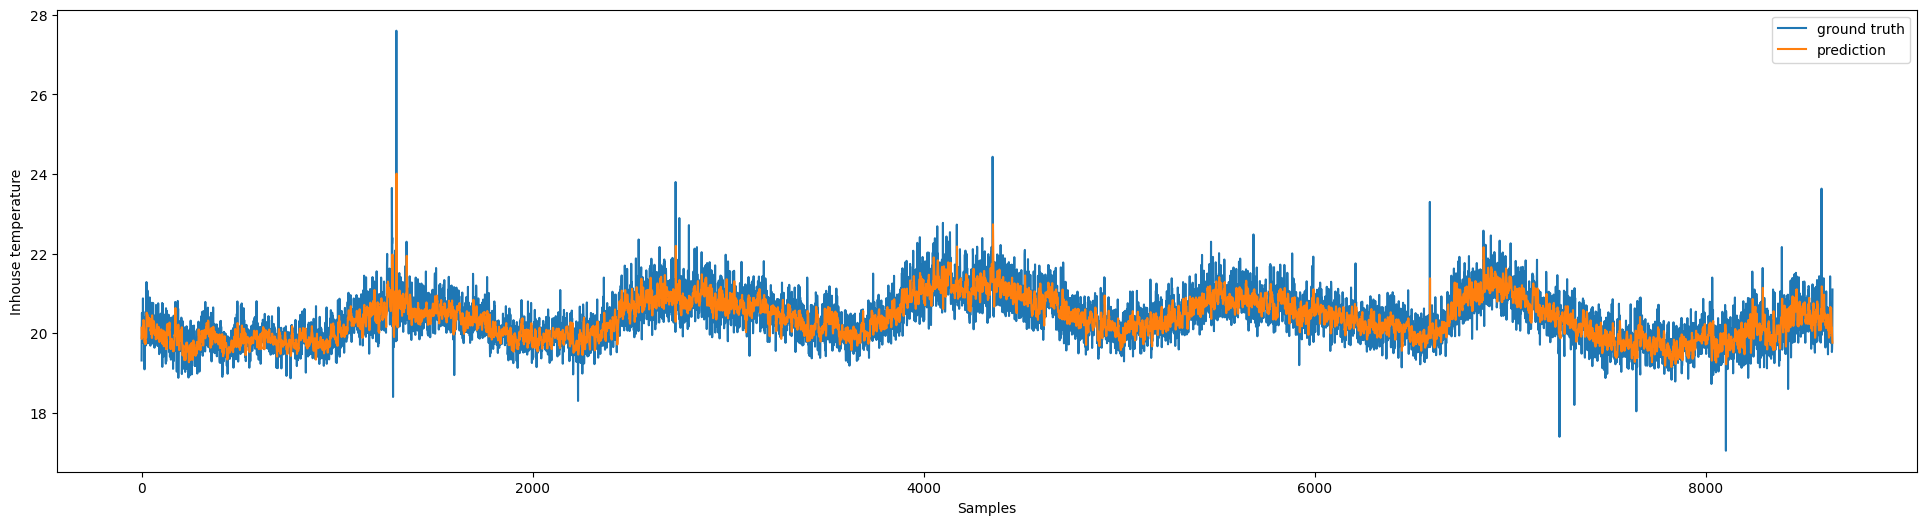

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
i=0
# MSE
mse = mean_squared_error(y_test[:,:,i], seq2seq_pred[:,:,i])
print('Mean Squared Error:', mse)

# Ploting
plt.figure(figsize=(24,6))
plt.plot(y_test[:,:,i])
plt.plot(seq2seq_pred[:,:,i])
plt.xlabel('Samples')
plt.ylabel('Inhouse temperature')
plt.legend(["ground truth", "prediction", ])

## New

In [ ]:
data_time_index = data.set_index('new_date')

In [ ]:
data_time_index

In [ ]:
data_time_index['inhouse_humidity'].isnull().unique()

In [ ]:
train_data = data_time_index[:65000]
val_data = data_time_index[65000:75000]
test_data = data_time_index[75000:]

In [ ]:
data_time_index[800:810]

In [ ]:
my_data = train_data[0:801]

In [ ]:
my_data.index = pd.DatetimeIndex(my_data.index.values, freq=my_data.index.inferred_freq)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
inhouse_humid_ag = AutoReg(my_data['inhouse_temperature'][0:600], \
                          lags = 8, \
                          trend='c', \
                          seasonal = True, \
                          exog = None, \
                          hold_back = None, \
                          period = None, \
                          missing = 'none')
fit_ih = inhouse_humid_ag.fit()

In [ ]:
pred = fit_ih.predict(start=600, end=800, dynamic=False)

In [ ]:
pred

In [ ]:
len(pred)

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# MSE
mse = mean_squared_error(my_data['inhouse_humidity'][600:801], pred)
print('Mean Squared Error:', mse)

# Ploting
plt.figure(figsize=(24,6))
plt.plot(my_data['inhouse_humidity'][600:801])
plt.plot(pred)
plt.legend(["ground truth", "prediction", ])

In [ ]:
!pip install pmdarima

In [ ]:
from bigdl.chronos.forecaster.arima_forecaster import ARIMAForecaster

arima_inhouse_humid = ARIMAForecaster()
arima_inhouse_humid.fit(train_data['inhouse_humidity'].values, val_data['inhouse_humidity'].values)

In [ ]:
inhouse_humid_result = arima_inhouse_humid.predict(horizon=1, rolling=True)

In [ ]:
inhouse_humid_result

# Streaming part

## Create streaming pyspark dataframe

In [ ]:
import os
for i in range(0,5):
  os.remove(f"/content/streaming/myFile{i}.csv")

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 30
pd.options.display.max_colwidth = 150



# SETTINGS
IN_PATH = "/content/streaming"

spark = SparkSession.builder.appName("Weather_classification").getOrCreate()
schema = spark.read.option('header',True).csv(IN_PATH).limit(10).schema

spark_reader = spark.readStream.option('header', True).schema(schema)

In [ ]:
df = (
    spark_reader.csv(IN_PATH).select(
        "new_date",
        "inhouse_temperature",
        "inhouse_humidity",
        "temp",
        "weather",
        "wind_speed",
        "humidity",
        "barometer",
        "visibility",
    ).coalesce(1)
)

In [ ]:
i = 2
if not df.isStreaming:
    print("This data is not for streaming")
    df.show()
    display(df.limit(5).toPandas())
else:
    print("Streaming Successfully")
    stream_writer = (
        df.writeStream
        .queryName(f"weather{i}")
        .outputMode("append")
        .format("memory")
    )
    query = stream_writer.start()

Streaming Successfully


## Preprocess for new data

In [ ]:
def xu_ly_thoi_gian(ngay, thang, nam, gio, phut):
    # Xử lý phút
    gio_moi = gio + phut // 60
    phut_moi = phut % 60

    # Xử lý giờ
    ngay_moi = ngay + gio_moi // 24
    gio_moi = gio_moi % 24

    # Xử lý tháng và năm
    if thang in [1, 3, 5, 7, 8, 10, 12]:
        if ngay_moi > 31:
            ngay_moi -= 31
            thang += 1
            if thang > 12:
                thang = 1
                nam += 1
    elif thang in [4, 6, 9, 11]:
        if ngay_moi > 30:
            ngay_moi -= 30
            thang += 1
    else:  # Tháng 2
        if (nam % 4 == 0 and nam % 100 != 0) or nam % 400 == 0:
            if ngay_moi > 29:
                ngay_moi -= 29
                thang += 1
        else:
            if ngay_moi > 28:
                ngay_moi -= 28
                thang += 1

    # Xử lý năm
    if thang > 12:
        thang = 1
        nam += 1

    # Chuyển định dạng ngày, tháng, năm, giờ, phút thành chuỗi và thêm số 0 đằng trước (nếu cần)
    ngay_moi = str(ngay_moi).zfill(2)
    thang_moi = str(thang).zfill(2)
    nam_moi = str(nam)
    gio_moi = str(gio_moi).zfill(2)
    phut_moi = str(phut_moi).zfill(2)

    return pd.to_datetime(nam_moi+"-"+thang_moi+"-"+ngay_moi+" "+gio_moi+":"+phut_moi)

## Streaming & giving continuous predictions

In [ ]:
true = pd.read_csv("/content/raw.csv")

In [ ]:
from IPython.display import clear_output
from time import sleep
for count in range(0, 25):
  # spark.sql can be used to request how the query is performing
  display(spark.sql(f"SELECT * from {query.name}").toPandas().sort_values('new_date').set_index('new_date'))

  df_streaming_pd = spark.sql(f"SELECT * from {query.name} ").toPandas().sort_values('new_date')
  df_streaming_pd['new_date'] = pd.to_datetime(df_streaming_pd['new_date'])

  tsdata = TSDataset.from_pandas(df_streaming_pd, dt_col="new_date",
                                 target_col=["inhouse_temperature", "inhouse_humidity",  "temp", "weather",
                                             "wind_speed", "humidity", "barometer", "visibility"])

  lookback, horizon = 5, 0
  tsdata.deduplicate()\
          .gen_dt_feature(features=['MINUTE', 'DAY', 'HOUR', 'MONTH', 'YEAR', ])\
          .impute()\
          .roll(lookback=lookback, horizon=horizon)

  x = tsdata.to_numpy()

  pred = tcn_forecaster.predict(x)

  a=[]
  for i in range(x.shape[0]):
    b = []
    dmyhm = [9, 11, 12, 10, 8]
    for j in dmyhm:
      if (j==8):
        b.append(int(x[i][lookback-1][j])+1)
      else:
        b.append(int(x[i][lookback-1][j]))
    a.append(b)

  a_new = []
  for i in range(len(a)):
    a_new.append(xu_ly_thoi_gian(a[i][0], a[i][1], a[i][2], a[i][3], a[i][4]))

  data_streaming = {
    "new_date": a_new,
    "inhouse_temperature": pred[:,:,0].reshape(-1),
    "inhouse_humidity": pred[:,:,1].reshape(-1),
    "temp": pred[:,:,2].reshape(-1),
    "weather": pred[:,:,3].reshape(-1),
    "wind_speed": pred[:,:,4].reshape(-1),
    "humidity": pred[:,:,5].reshape(-1),
    "barometer": pred[:,:,6].reshape(-1),
    "visibility": pred[:,:,7].reshape(-1),
  }
  df_pandas = pd.DataFrame(data_streaming)
  print("Predict result:")
  print(df_pandas.tail(1)[["new_date", "inhouse_temperature"]])

  # MSE
  mse = mean_squared_error(true['inhouse_temperature'][5:6+count].values, df_pandas['inhouse_temperature'].values)
  print('Mean Squared Error:', mse)

  # Ploting
  plt.figure(figsize=(24,6))
  plt.plot(true['inhouse_temperature'][5:6+count].values)
  plt.plot(df_pandas['inhouse_temperature'].values)
  plt.legend(["ground truth", "prediction", ])
  plt.show()

  df_pandas.tail(1).to_csv(f"/content/streaming/myFile{count}.csv", index=False)
  sleep(6)
  plt.clf()
  clear_output(wait=True)
else:
  print("Live view ended...")

Live view ended...


<Figure size 640x480 with 0 Axes>

# Stuffs

In [ ]:
# MSE
mse = mean_squared_error(true['inhouse_temperature'][5:10].values, df_pandas['inhouse_temperature'].values)
print('Mean Squared Error:', mse)

# Ploting
plt.figure(figsize=(24,6))
plt.plot(true['inhouse_temperature'][5:10].values)
plt.plot(df_pandas['inhouse_temperature'].values)
plt.legend(["ground truth", "prediction", ])

In [ ]:
  df_streaming_pd = spark.sql(f"SELECT * from {query.name} ").toPandas().sort_values('new_date')
  df_streaming_pd['new_date'] = pd.to_datetime(df_streaming_pd['new_date'])

  tsdata = TSDataset.from_pandas(df_streaming_pd, dt_col="new_date",
                                 target_col=["inhouse_temperature", "inhouse_humidity",  "temp", "weather",
                                             "wind_speed", "humidity", "barometer", "visibility"])

  lookback, horizon = 5, 0
  tsdata.deduplicate()\
          .gen_dt_feature(features=['MINUTE', 'DAY', 'HOUR', 'MONTH', 'YEAR', ])\
          .impute()\
          .roll(lookback=lookback, horizon=horizon)

  x = tsdata.to_numpy()

  pred = forecaster.predict(x)

  a=[]
  for i in range(x.shape[0]):
    b = []
    dmyhm = [9, 11, 12, 10, 8]
    for j in dmyhm:
      if (j==8):
        b.append(int(x[i][4][j])+1)
      else:
        b.append(int(x[i][4][j]))
    a.append(b)

  a_new = []
  for i in range(len(a)):
    a_new.append(xu_ly_thoi_gian(a[i][0], a[i][1], a[i][2], a[i][3], a[i][4]))

  data = {
    "new_date": pd.to_datetime(a_new),
    "inhouse_temperature": pred[:,:,0].reshape(-1),
    "inhouse_humidity": pred[:,:,1].reshape(-1),
    "temp": pred[:,:,2].reshape(-1),
    "weather": pred[:,:,3].reshape(-1),
    "wind_speed": pred[:,:,4].reshape(-1),
    "humidity": pred[:,:,5].reshape(-1),
    "barometer": pred[:,:,6].reshape(-1),
    "visibility": pred[:,:,7].reshape(-1),
  }
  df_pandas = pd.DataFrame(data)
  print("Predict result:")
  print(df_pandas[["new_date", "inhouse_temperature"]])